# Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.023 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 30.141 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.027 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 30.168 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 71.434 MiB RAM in 0.472s, peaked 24.598 MiB above current, total RAM usage 101.602 MiB


In [4]:
lens = pd.merge(movies, ratings)

In [4] used 62.375 MiB RAM in 0.132s, peaked 30.871 MiB above current, total RAM usage 163.977 MiB


In [5]:
size_pandas = mw.measurements.memory_delta
size_pandas

62.375

In [5] used 0.043 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 164.020 MiB


In [6]:
print(lens[:10])
lens.info()

   movie_id             title                       genres  user_id  rating  \
0         1  Toy Story (1995)  Animation|Children's|Comedy        1       5   
1         1  Toy Story (1995)  Animation|Children's|Comedy        6       4   
2         1  Toy Story (1995)  Animation|Children's|Comedy        8       4   
3         1  Toy Story (1995)  Animation|Children's|Comedy        9       5   
4         1  Toy Story (1995)  Animation|Children's|Comedy       10       5   
5         1  Toy Story (1995)  Animation|Children's|Comedy       18       4   
6         1  Toy Story (1995)  Animation|Children's|Comedy       19       5   
7         1  Toy Story (1995)  Animation|Children's|Comedy       21       3   
8         1  Toy Story (1995)  Animation|Children's|Comedy       23       4   
9         1  Toy Story (1995)  Animation|Children's|Comedy       26       3   

   unix_timestamp  
0       978824268  
1       978237008  
2       978233496  
3       978225952  
4       978226474  
5       97

In [7]:
size_pandas2 = lens.memory_usage().sum(index=True) / 2**20.
size_pandas2

45.785934448242188

In [7] used 0.031 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 178.371 MiB


In [8]:
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 31.3 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [8] used 0.215 MiB RAM in 1.337s, peaked 0.000 MiB above current, total RAM usage 178.586 MiB


In [9]:
qtime_pandas = t.best

In [9] used 0.004 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 178.590 MiB


## Use a compressed in-memory container via `bcolz`

In [10]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     0.12.1.dev2
NumPy version:     1.10.1
Blosc version:     1.4.1 ($Date:: 2014-07-08 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.4.4
Python version:    2.7.10 |Continuum Analytics, Inc.| (default, Oct 19 2015, 18:04:42) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


8

In [10] used 0.688 MiB RAM in 0.013s, peaked 0.000 MiB above current, total RAM usage 179.277 MiB


In [11]:
zlens = bcolz.ctable.fromdataframe(lens)

In [11] used 0.480 MiB RAM in 0.174s, peaked 0.652 MiB above current, total RAM usage 179.758 MiB


In [12]:
size_bcolz = mw.measurements.memory_delta
size_bcolz

0.48046875

In [12] used 0.020 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 179.777 MiB


Sometimes the memory reported as used is too much biased (don't know why), so let's repeat the operation, but using a different container:

In [13]:
zlens2 = bcolz.ctable.fromdataframe(lens)

In [13] used 0.059 MiB RAM in 0.173s, peaked 0.945 MiB above current, total RAM usage 179.836 MiB


In [14]:
size_bcolz2 = zlens2.cbytes / 2**20.
size_bcolz2

7.894172668457031

In [14] used 0.020 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 179.855 MiB


In [15]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.89 MB; ratio: 19.45
  cparams := cparams(clevel=5, shuffle=True, cname='lz4')
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [15] used 0.012 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 179.867 MiB


In [16]:
size_pandas / size_bcolz

129.8211382113821

In [16] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 179.867 MiB


We can see that the space taken by a bcolz container is more than 100x smaller (!) than a pandas one.

### Excercise

Why do you think that the number of uncompressed bytes (nbytes) that the ctable reports is 3x more than pandas (153 MB vs 54 MB)?

*Hint:* Pandas stores the string columns in NumPy containers with 'object' dtype whereas bcolz uses the equivalent to NumPy's 'string' objects.

In [17]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

100 loops, best of 3: 18.8 ms per loop
In [17] used 3.152 MiB RAM in 7.869s, peaked 0.000 MiB above current, total RAM usage 183.020 MiB


In [18]:
qtime_bcolz = t.best

In [18] used 0.020 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 183.039 MiB


In [19]:
qtime_pandas / qtime_bcolz

1.66517625278669

In [19] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 183.039 MiB


We see that bcolz containers, besides being in compressed state, provide ~1.8x faster query times than pandas

In [20]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

('results with pandas Dataframe:', 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64)
('results with bcolz ctable:', [(5121, 75), (5164, 3842), (5187, 6031)])
In [20] used 0.004 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 183.043 MiB


## Using structured NumPy arrays

In [21]:
nalens = lens.to_records()

In [21] used 53.418 MiB RAM in 0.436s, peaked 0.000 MiB above current, total RAM usage 236.461 MiB


In [22]:
size_numpy = mw.measurements.memory_delta
size_numpy

53.41796875

In [22] used 0.023 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 236.484 MiB


In [23]:
nalens

rec.array([ (0, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268),
 (1, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008),
 (2, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496),
 ...,
 (1000206, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656),
 (1000207, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537),
 (1000208, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', '|O'), ('genres', '|O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [23] used 0.004 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 236.488 MiB


In [24]:
size_numpy2 = round((nalens.size * nalens.dtype.itemsize) / 2**20., 3)
size_numpy2

53.417

In [24] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 236.488 MiB


In [25]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 13.6 ms per loop


rec.array([ (5121, 8, 'Tom and Huck (1995)', "Adventure|Children's", 75, 5, 977851520),
 (5164, 8, 'Tom and Huck (1995)', "Adventure|Children's", 3842, 5, 967986151),
 (5187, 8, 'Tom and Huck (1995)', "Adventure|Children's", 6031, 5, 956718223)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', '|O'), ('genres', '|O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [25] used 0.023 MiB RAM in 5.707s, peaked 0.000 MiB above current, total RAM usage 236.512 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas.

In [26]:
qtime_numpy = t.best

In [26] used 0.023 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 236.535 MiB


## Performance comparsion

In [27]:
%matplotlib inline

In [27] used 5.574 MiB RAM in 0.069s, peaked 0.004 MiB above current, total RAM usage 242.109 MiB


/home/francesc/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


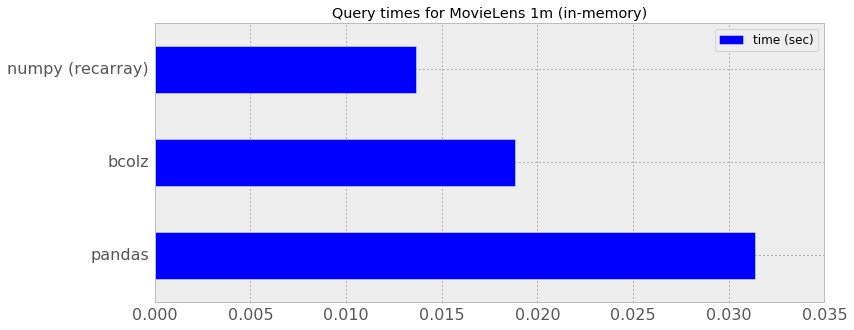

In [28] used 4.715 MiB RAM in 0.225s, peaked 0.000 MiB above current, total RAM usage 246.824 MiB


In [28]:
# Query times
labels = ["pandas", "bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

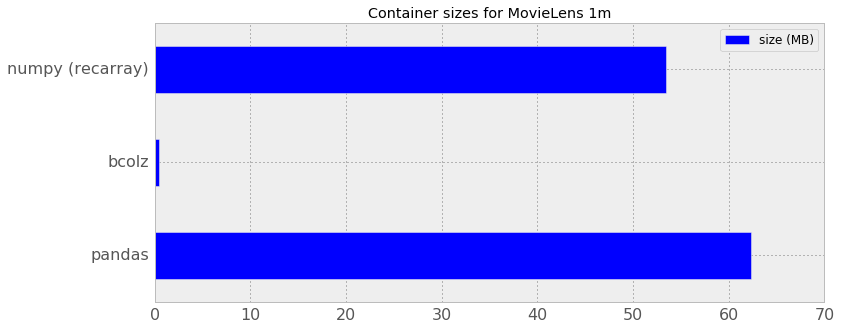

In [29] used 3.609 MiB RAM in 0.180s, peaked 0.000 MiB above current, total RAM usage 250.434 MiB


In [29]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas, size_bcolz, size_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)